In [1]:
pip install pandas numpy statsmodels matplotlib


Checking stationarity for A1_Score:
ADF Statistic: -6.802047514029919
p-value: 2.2242910373784252e-09
Checking stationarity for A2_Score:
ADF Statistic: -15.649920664319113
p-value: 1.6012129167903329e-28


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Apr, 2025
Time:                     14:32:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.39515
Nobs:                     550.000    HQIC:                  -2.63385
Log likelihood:          -744.418    FPE:                  0.0616159
AIC:                     -2.78696    Det(Omega_mle):       0.0563745
--------------------------------------------------------------------
Results for equation A1_Score
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001322         0.020100            0.066           0.948
L1.A1_Score         -0.900999         0.043692          -20.622           0.000
L1.A2_Score          0.016223         0.040562            0.4

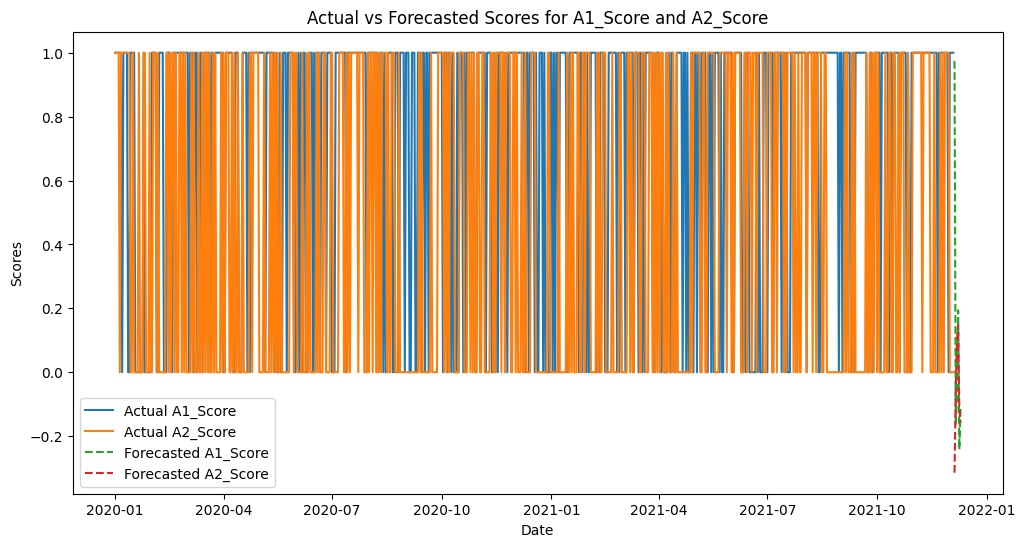

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Step 1: Load the dataset (replace with your actual dataset)
df = pd.read_csv("autism_screening.csv")  # Replace with your actual dataset path

# Step 2: Create a synthetic date column (if not present)
df['date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
df.set_index('date', inplace=True)

# Step 3: Create a few columns for prediction (for simplicity, using A1_Score and A2_Score)
df_subset = df[['A1_Score', 'A2_Score']]

# Step 4: Check for stationarity of each column (ADF test)
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")

print("Checking stationarity for A1_Score:")
check_stationarity(df_subset['A1_Score'])
print("Checking stationarity for A2_Score:")
check_stationarity(df_subset['A2_Score'])

# Step 5: Make data stationary (if needed, by differencing)
df_subset_diff = df_subset.diff().dropna()

# Step 6: Train-Test Split (80% training, 20% test)
train_size = int(len(df_subset_diff) * 0.8)
train, test = df_subset_diff[:train_size], df_subset_diff[train_size:]

# Step 7: Fit the VAR Model
model = VAR(train)
model_fitted = model.fit(maxlags=15, ic='aic')  # Use AIC to select the optimal lag length

# Step 8: Check the summary of the model
print(model_fitted.summary())

# Step 9: Make Forecasts (let's predict the next 6 time steps)
forecast_steps = 6
forecast = model_fitted.forecast(train.values[-model_fitted.k_ar:], steps=forecast_steps)

# Step 10: Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=df_subset.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=df_subset.columns)

# Step 11: Visualize the Actual vs Forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset['A1_Score'], label="Actual A1_Score")
plt.plot(df_subset.index, df_subset['A2_Score'], label="Actual A2_Score")
plt.plot(forecast_df.index, forecast_df['A1_Score'], label="Forecasted A1_Score", linestyle='--')
plt.plot(forecast_df.index, forecast_df['A2_Score'], label="Forecasted A2_Score", linestyle='--')
plt.title("Actual vs Forecasted Scores for A1_Score and A2_Score")
plt.xlabel("Date")
plt.ylabel("Scores")
plt.legend()
plt.show()
